# Imports and loading data

In [1]:
import numpy as np
import os, time
import matplotlib.pyplot as plt
import pickle as pkl
from ESN.ESN import ESN, LCESN, EESN, DHESN
from MackeyGlass.MackeyGlassGenerator import run
from Helper.utils import nrmse, _DEFAULT_SPECS_
from ipywidgets import IntProgress
from IPython.display import display

data = np.array(run(21100)).reshape(-1, 1)
split = 20000
X_train = data[:split-1]
y_train = data[1:split]
valid_data = data[split:].squeeze()

data_mean = np.mean(data.squeeze())

# zero the data (for PCA)
X_train -= data_mean
y_train -= data_mean
valid_data -= data_mean

DONE


# Test methods

In [6]:
def run_test(esn_class, all_results, specs, n_runs=50, show_plots=False, fname=None):
    """
    Generic method running tests on ESN.
    
    (ESN.LayeredESN)    esn_class: choose from [ESN, LCESN, DHESN, EESN].
              (dict)  all_results: dictionary to save results in.
              (dict)        specs: network specifications dictionary.
               (str)        fname: filename to save results under.
    """
    assert esn_class in [ESN, LCESN, EESN, DHESN]
    
    echo_params = specs['echo_params']
    regulariser = specs['regulariser']
    num_reservoirs = specs['num_reservoirs']
    reservoir_sizes = specs['reservoir_sizes']
    in_weights = specs['in_weights']
    res_weights = specs['res_weights']
    
    in_notebook = os.environ['_'][-7:] == 'jupyter'
    
    if in_notebook:
        progress_bar = IntProgress(value=0, min=0, max=n_runs)
        display(progress_bar)
        
    results = []
    start_time = time.time()
    for run_num in range(n_runs):
        if not in_notebook:
            print('Run %d' % (run_num+1))
        # create and train model
        lcesn = esn_class(1, 1, num_reservoirs, reservoir_sizes, echo_params, 
                      regulariser=regulariser)
        lcesn.initialize_input_weights(
            strategies=in_weights['strategies'], scales=in_weights['scales'],
            offsets=in_weights['offsets']
        )
        lcesn.initialize_reservoir_weights(
            strategies=res_weights['strategies'], spectral_scales=res_weights['spectral_scales'],
            offsets=res_weights['offsets']
        )
        lcesn.train(X_train, y_train, debug_info=True)
        lcesn_outputs = []

        # generative tests
        u_n = data[split-1]
        for _ in range(len(valid_data)):
            u_n = lcesn.forward(u_n)
            lcesn_outputs.append(u_n)

        lcesn_outputs = np.array(lcesn_outputs).squeeze()

        error = nrmse(valid_data, lcesn_outputs, data_mean)
        print('NRMSE: %f\n' % error)
        results.append(error)
        
        if show_plots:
            f, ax = plt.subplots(figsize=(12, 10))
            xs = range(len(valid_data))
            ax.plot(xs, lcesn_outputs, label='Generated')
            ax.plot(xs, valid_data, label='True')
            plt.legend()
            plt.show()
            raw_input()
        
        if in_notebook:
            if run_num == n_runs - 1:
                progress_bar.close()
            else:
                progress_bar.value += 1

    total_time = time.time() - start_time
    print('Took %.3f seconds' % total_time)
    n_runs = len(results)
    key = [
        'echo_params: %f' % echo_params, 'regulariser: %f' % regulariser,
        'num_reservoirs: %d' % num_reservoirs, 'reservoir_sizes: %s' % reservoir_sizes,
        'in_weights: %s' % in_weights.items(), 'res_weights: %s' % res_weights.items()
    ]
    for i in range(len(key)-1):
        key[i] += '\n'
    key = ''.join(key)

    if key not in all_results.keys():
        all_results[key] = []

    all_results[key].extend(results)
    
    while 1:
        ch = raw_input('make sure you\'re not overriding old results. (y/n)')
        if ch == 'y':
            if fname is None:
                print('must provide a filename to save results')
                break
            elif fname[-2:] != '.p': 
                fname += '.p'
            
            class_str = str(esn_class)[16:-2]
            assert class_str in ['ESN', 'DHESN', 'LCESN', 'EESN']
            
            pkl.dump(all_results, open('Results/%s/%s.p' % (class_str, fname), 'wb'))
            break
        elif ch == 'n':
            print('okay, returning updated results dictionary instead')
            break
    
    return all_results

def show_nrmse_histograms(all_results, n_bins=30):
    for k, res in all_results.items():
        specs = k.split('\n')
        specs_dict = dict()
        for s in specs:
            #print(s)
            if 'reservoir_sizes' in s:
                sizes = s[s.index(':')+2:][1:-1]
                sizes = map(int, sizes.split(','))
            elif 'in_weights' in s or 'res_weights' in s:
                info = s[s.index(':')+2:]
                exec('info = dict(%s)' % info)
                k_ = 'in_weights' if 'in_weights' in s else 'res_weights'
                specs_dict[k_] = info
            else:
                k1 = "'%s'" % s[:s.index(':')]
                k2 = s[s.index(':') + 2:]
                exec('specs_dict[%s] = %s' % (k1, k2))

        # Check for infs, nans
        num_failed = 0
        res_clean = []
        for err in res:
            if np.isnan(err) or np.isinf(err) or err >= 1.:
                num_failed += 1
            else:
                res_clean.append(err)
        
        title = 'reg:%s. offset:%.1f. n_runs=%d. num_failures=%d' \
                    % (str(specs_dict['regulariser']), specs_dict['res_weights']['offsets'],
                       len(res), num_failed)
        if len(res_clean) > 0:
            hist, bins = np.histogram(res_clean, bins=min(len(res_clean), n_bins))
            bin_width = bins[1] - bins[0]

            f, ax = plt.subplots(figsize=(12, 6))
            ax.set_title(title)
            ax.bar(bins[:-1], hist, width=bin_width)
            plt.show()
        else:
            print('"%s" only yielded failures. oops' % title)
        raw_input()

# Run experiments

In [4]:
all_results = pkl.load(open('Results/LCESN/7_March2.p', 'rb'))

In [ ]:
specs = _DEFAULT_SPECS_
specs['reservoir_sizes'] = [300, 230, 170, 100, 50]
specs['spectral_scales'] = np.linspace(0.8, 0.9, 5)
specs['in_weights']['scales'] = 0.1

for k, v in specs.items():
    print(k, v)

all_results = run_test(DHESN, all_results, specs, n_runs=5, show_plots=True, 
                       fname='11_March.p')

# NRMSE histograms

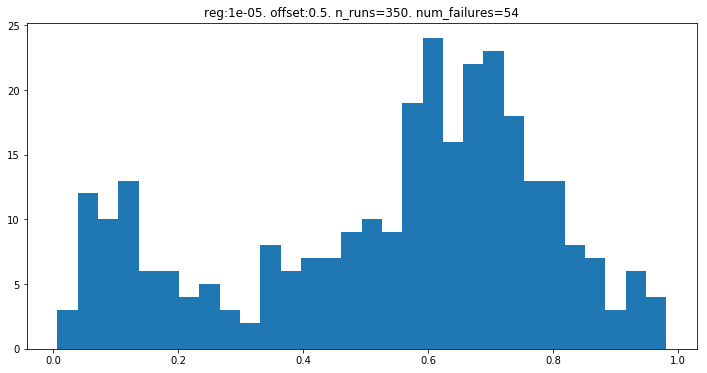

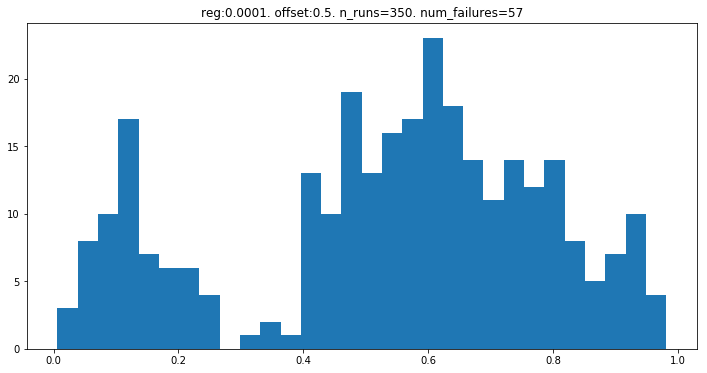

In [7]:
show_nrmse_histograms(all_results)